In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score, accuracy_score, confusion_matrix
import xgboost as xgb

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_pickle("Data/df.pkl")
df.dropna(inplace = True)

In [3]:
y_probs_1 = np.load('Data/y_probs_1.npy')
y_probs_2 = np.load('Data/y_probs_2.npy')
y_test_custom = np.load('Data/y_test_custom.npy')

In [4]:
df.head(3)

,Date,10_Year,3_Month,Recession,Consumer Sentiment,10Y-3M,Copper/Gold,10Y-3M 6M Forward,10Y-3M 9M Forward,10Y-3M 12M Forward,C Sentiment 6M Forward,C Sentiment 9M Forward,C Sentiment 12M Forward,C/G 6M Forward,C/G 9M Forward,C/G 12M Forward
12,1970-07-01,7.46,6.45,1,98.817431,1.01,-4.074425,-0.28,0.23,0.19,99.919902,100.677831,100.612032,-4.191297,-4.460540,-4.488816
13,1970-08-01,7.53,6.41,1,98.703005,1.12,-4.145388,-0.29,0.25,0.33,99.678861,100.851819,100.596721,-4.081967,-4.426410,-4.493680
14,1970-09-01,7.39,6.12,1,98.557545,1.27,-4.147906,0.07,0.07,0.27,99.441214,101.045913,100.603771,-4.124309,-4.405909,-4.420542


## Random Forest Classifier

In [5]:
#Converting features and labels to arrays for RF Classifier
labels = np.array(df['Recession'])
dates = df['Date']
features = df[['10Y-3M 6M Forward','C Sentiment 6M Forward','C/G 6M Forward']]
feature_list = list(features.columns)
features = np.array(features)

In [6]:
#Train, test split. Cannot do k-folds due to time series data
train_features, test_features = np.split(features, [int(.67 *len(features))])
train_labels, test_labels = np.split(labels, [int(.67 *len(labels))])

In [7]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (303, 3)
Training Labels Shape: (303,)
Testing Features Shape: (150, 3)
Testing Labels Shape: (150,)


In [8]:
def rolling_6(y_test):
    """
    Helper function to convert y_test to rolling 6 month window. 
    Returns numpy array: If recession occurs in 6 month window from index, returns 1. Otherwise, returns 0
    """
    rec_6_months = []
    
    for i in range(len(y_test)):
        if np.sum(y_test[i:i+6]) > 0:
            
            rec_6_months.append(1)    
        
        else:
            rec_6_months.append(0)
                
    return np.array(rec_6_months)

In [9]:
train_labels_custom = rolling_6(train_labels)
test_labels_custom = rolling_6(test_labels)

In [10]:
# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 3000, max_depth = 2, random_state = 10)

# Train the model on training data
rf.fit(train_features, train_labels);

In [11]:
predictions = rf.predict_proba(test_features) 

In [12]:
y_predict_3 = rf.predict(test_features)
print("The score for Random Forest is")
#score returns mean accuracy
print("Training: {:6.2f}%".format(100*rf.score(train_features, train_labels_custom)))
print("Test set: {:6.2f}%".format(100*rf.score(test_features, test_labels_custom)))
print("Default threshold: 0.5")
print("Precision: {:6.4f}".format(precision_score(test_labels_custom, y_predict_3)))

The score for Random Forest is
Training:  85.48%
Test set:  84.67%
Default threshold: 0.5
Precision: 0.0000


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [13]:
def make_confusion_matrix(model, threshold=0.3):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict_3 = (rf.predict_proba(train_features)[:, 1] >= threshold)
    default_confusion = confusion_matrix(train_labels_custom, y_predict_3)
    plt.figure(dpi=80)
    sns.heatmap(default_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['Growth', 'Recession'],
           yticklabels=['Growth', 'Recession']);
    plt.xlabel('prediction')
    plt.ylabel('actual')
    print("F1: {:6.4f}, Precision: {:6.4f},   Recall: {:6.4f}".format(fbeta_score(train_labels_custom, y_predict_3, beta = 1),
                                                                           precision_score(train_labels_custom, y_predict_3), 
                                                                           recall_score(train_labels_custom, y_predict_3)))

F1: 0.5977, Precision: 0.8125,   Recall: 0.4727


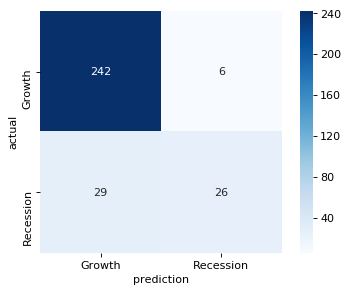

In [14]:
make_confusion_matrix(rf, 0.2)

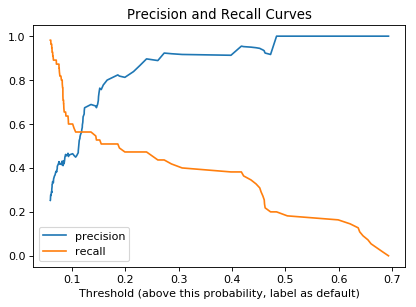

In [15]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(train_labels_custom, 
                                                                        rf.predict_proba(train_features)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as default)');
plt.title('Precision and Recall Curves')

fig_1 = plt.gcf()
fig_1.savefig('Data/logit_curves_1', format='png');

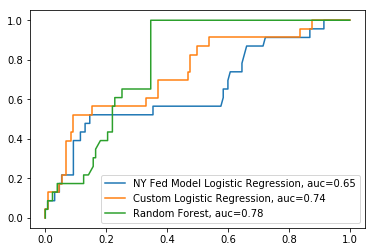

In [16]:
plt.figure(0).clf()

fpr, tpr, thresh = metrics.roc_curve(y_test_custom, y_probs_1[:,1])
auc = metrics.roc_auc_score(y_test_custom, y_probs_1[:,1])
plt.plot(fpr,tpr,label="NY Fed Model Logistic Regression, auc="+str(round(auc,2)))

fpr, tpr, thresh = metrics.roc_curve(y_test_custom, y_probs_2[:,1])
auc = metrics.roc_auc_score(y_test_custom, y_probs_2[:,1])
plt.plot(fpr,tpr,label="Custom Logistic Regression, auc="+str(round(auc,2)))

fpr, tpr, thresh = metrics.roc_curve(test_labels_custom, predictions[:,1])
auc = metrics.roc_auc_score(test_labels_custom, predictions[:,1])
plt.plot(fpr,tpr,label="Random Forest, auc="+str(round(auc,2)))

plt.legend(loc='lower right');

/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


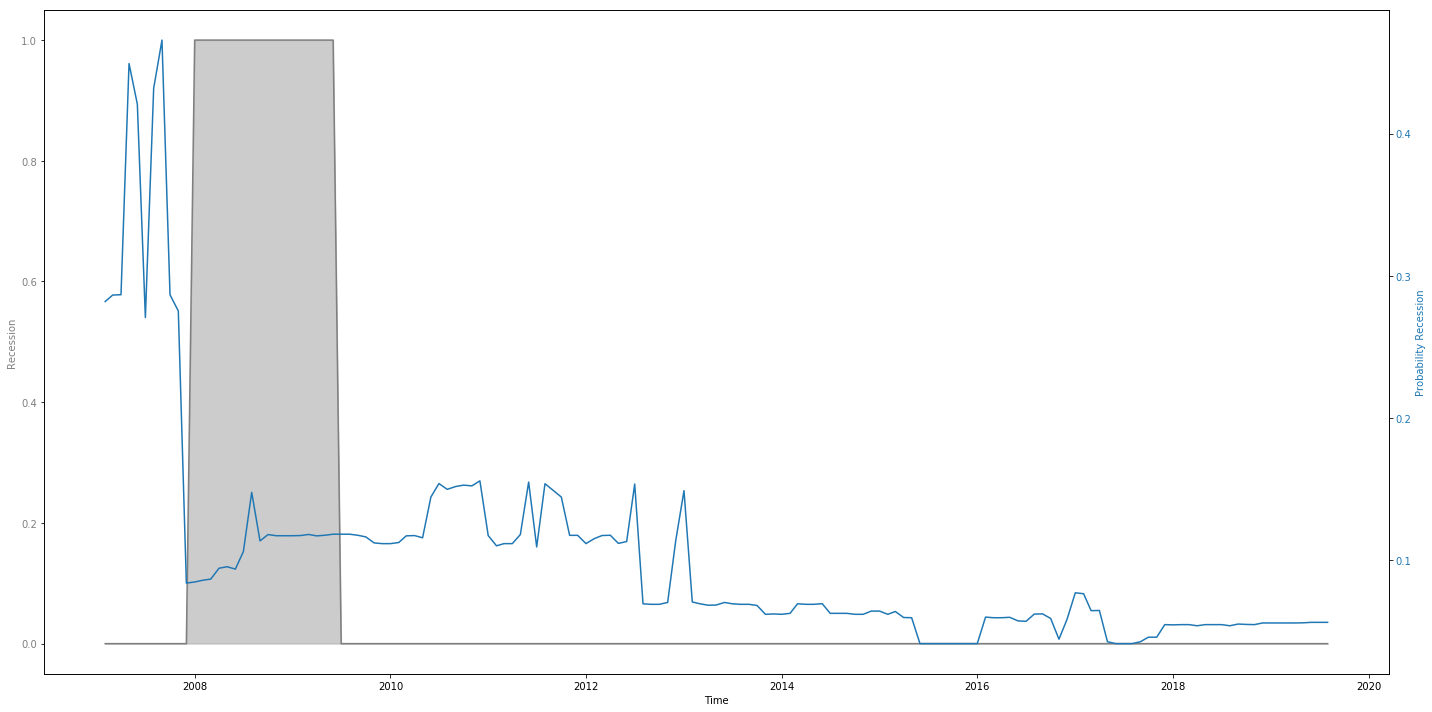

In [17]:
fig, ax1 = plt.subplots(figsize=(20,10))

test_labels = test_labels > 0
color = 'tab:grey'
ax1.set_xlabel('Time')
ax1.set_ylabel('Recession', color=color)
ax1.fill_between(dates[303:], 0, test_labels, alpha = 0.4, color = 'grey')
ax1.plot(dates[303:], test_labels, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Probability Recession', color=color)  
ax2.plot(dates[303:], predictions[:,1], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show();

In [18]:
df.tail(3)

,Date,10_Year,3_Month,Recession,Consumer Sentiment,10Y-3M,Copper/Gold,10Y-3M 6M Forward,10Y-3M 9M Forward,10Y-3M 12M Forward,C Sentiment 6M Forward,C Sentiment 9M Forward,C Sentiment 12M Forward,C/G 6M Forward,C/G 9M Forward,C/G 12M Forward
462,2019-06-01,2.07,2.17,0,101.340371,-0.10,-6.255557,0.46,0.87,1.01,101.072907,101.359585,101.298915,-6.188920,-6.047863,-6.046656
463,2019-07-01,2.06,2.10,0,101.072671,-0.04,-6.285235,0.34,0.90,0.93,100.876346,101.342390,101.268674,-6.163211,-6.126769,-6.065144
464,2019-08-01,1.63,1.95,0,100.575301,-0.32,-6.398405,0.29,0.79,0.86,100.928805,101.237183,101.279514,-6.107702,-6.083086,-6.118759


In [19]:
now = rf.predict_proba([[-0.32,100.575,-6.3984]])
now

array([[0.55532238, 0.44467762]])

## XGBoost

In [28]:
from xgboost import XGBClassifier
xgbmodel = XGBClassifier(max_depth = 2, learning_rate = 0.03, n_estimators = 300)
eval_set = [(train_features, train_labels)]
xgbmodel.fit(train_features, train_labels, eval_metric="error", eval_set=eval_set,
             early_stopping_rounds = 50, verbose=True)

[0]	validation_0-error:0.075908
Will train until validation_0-error hasn't improved in 50 rounds.
[1]	validation_0-error:0.075908
[2]	validation_0-error:0.075908
[3]	validation_0-error:0.075908
[4]	validation_0-error:0.069307
[5]	validation_0-error:0.069307
[6]	validation_0-error:0.069307
[7]	validation_0-error:0.069307
[8]	validation_0-error:0.069307
[9]	validation_0-error:0.069307
[10]	validation_0-error:0.069307
[11]	validation_0-error:0.069307
[12]	validation_0-error:0.069307
[13]	validation_0-error:0.069307
[14]	validation_0-error:0.069307
[15]	validation_0-error:0.069307
[16]	validation_0-error:0.069307
[17]	validation_0-error:0.069307
[18]	validation_0-error:0.069307
[19]	validation_0-error:0.069307
[20]	validation_0-error:0.069307
[21]	validation_0-error:0.069307
[22]	validation_0-error:0.069307
[23]	validation_0-error:0.069307
[24]	validation_0-error:0.069307
[25]	validation_0-error:0.069307
[26]	validation_0-error:0.069307
[27]	validation_0-error:0.069307
[28]	validation_0-er

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.03, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=None, n_estimators=300, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [29]:
xgb_proba = xgbmodel.predict_proba(test_features)

In [30]:
y_predict_4 = rf.predict(test_features)
print("The score for Random Forest is")
#score returns mean accuracy
print("Training: {:6.2f}%".format(100*rf.score(train_features, train_labels_custom)))
print("Test set: {:6.2f}%".format(100*rf.score(test_features, test_labels_custom)))
print("Default threshold: 0.5")
print("Precision: {:6.4f}".format(precision_score(test_labels_custom, y_predict_4)))

The score for Random Forest is
Training:  85.48%
Test set:  84.67%
Default threshold: 0.5
Precision: 0.0000


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [31]:
def make_confusion_matrix(model, threshold=0.3):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict_4 = (rf.predict_proba(train_features)[:, 1] >= threshold)
    default_confusion = confusion_matrix(train_labels_custom, y_predict_4)
    plt.figure(dpi=80)
    sns.heatmap(default_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['Growth', 'Recession'],
           yticklabels=['Growth', 'Recession']);
    plt.xlabel('prediction')
    plt.ylabel('actual')
    print("F1: {:6.4f}, Precision: {:6.4f},   Recall: {:6.4f}".format(fbeta_score(train_labels_custom, y_predict_4, beta = 1),
                                                                           precision_score(train_labels_custom, y_predict_4), 
                                                                           recall_score(train_labels_custom, y_predict_4)))

F1: 0.5977, Precision: 0.8125,   Recall: 0.4727


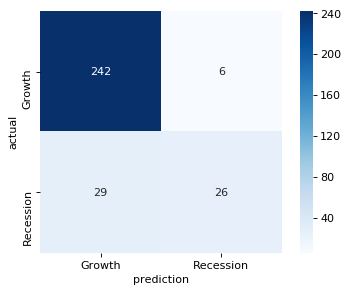

In [32]:
make_confusion_matrix(xgb, 0.2)

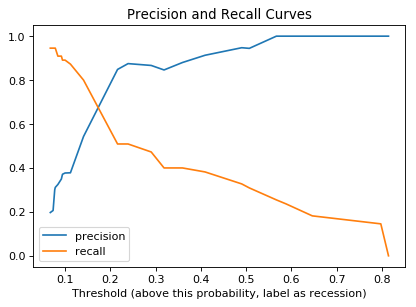

In [33]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(train_labels_custom, 
                                                                        xgbmodel.predict_proba(train_features)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as recession)');
plt.title('Precision and Recall Curves')

fig_1 = plt.gcf();

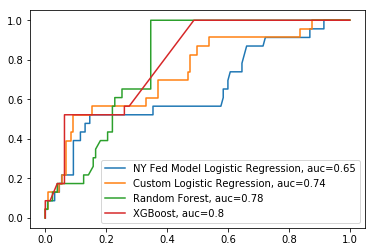

In [34]:
plt.figure(0).clf()

fpr, tpr, thresh = metrics.roc_curve(y_test_custom, y_probs_1[:,1])
auc = metrics.roc_auc_score(y_test_custom, y_probs_1[:,1])
plt.plot(fpr,tpr,label="NY Fed Model Logistic Regression, auc="+str(round(auc,2)))

fpr, tpr, thresh = metrics.roc_curve(y_test_custom, y_probs_2[:,1])
auc = metrics.roc_auc_score(y_test_custom, y_probs_2[:,1])
plt.plot(fpr,tpr,label="Custom Logistic Regression, auc="+str(round(auc,2)))

fpr, tpr, thresh = metrics.roc_curve(test_labels_custom, predictions[:,1])
auc = metrics.roc_auc_score(test_labels_custom, predictions[:,1])
plt.plot(fpr,tpr,label="Random Forest, auc="+str(round(auc,2)))

fpr, tpr, thresh = metrics.roc_curve(test_labels_custom, xgb_proba[:,1])
auc = metrics.roc_auc_score(test_labels_custom, xgb_proba[:,1])
plt.plot(fpr,tpr,label="XGBoost, auc="+str(round(auc,2)))

plt.legend(loc='lower right')
fig = plt.gcf()
fig.savefig('Data/ROC_curves', dpi = 300, format='png');

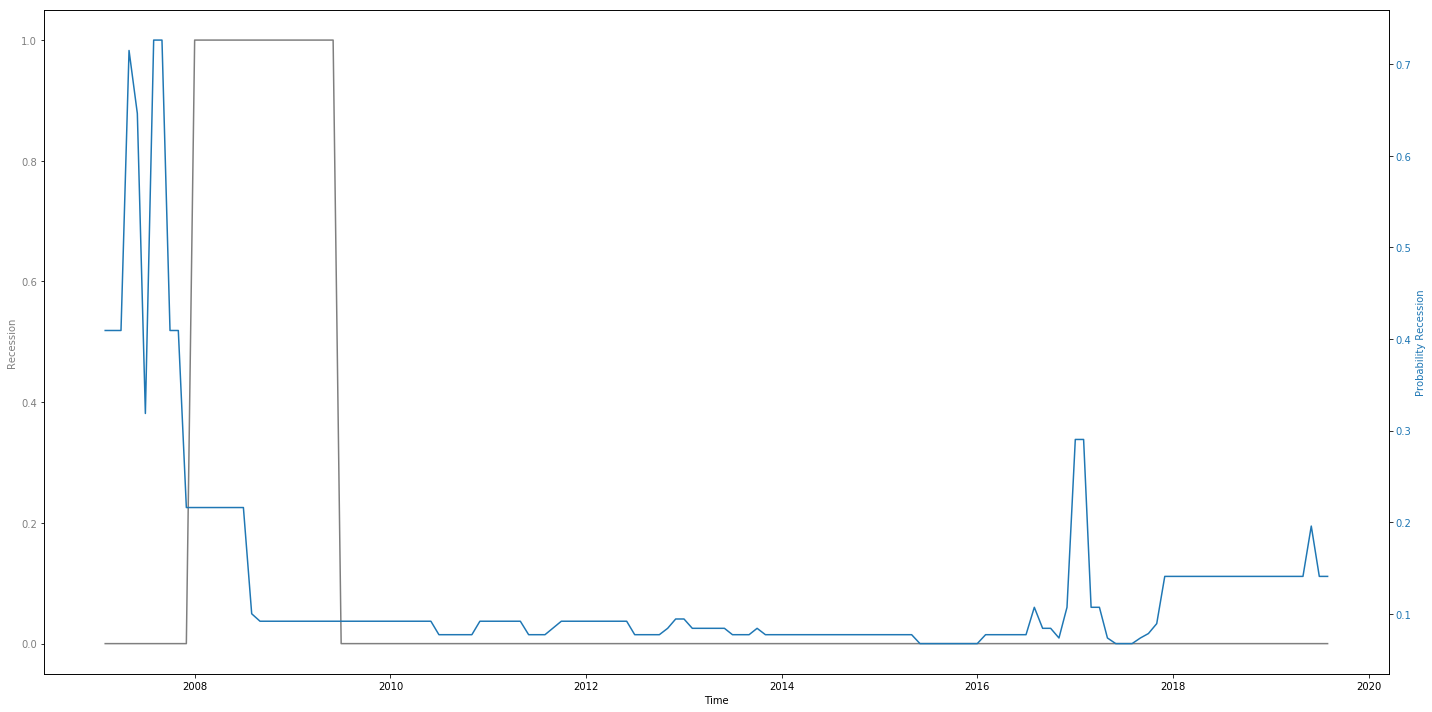

In [36]:
fig, ax1 = plt.subplots(figsize=(20,10))

color = 'tab:grey'
ax1.set_xlabel('Time')
ax1.set_ylabel('Recession', color=color)
ax1.plot(dates[303:], test_labels, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Probability Recession', color=color)  
ax2.plot(dates[303:], xgb_proba[:,1], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show();